In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Primary Installs

In [2]:
%cd '/content/drive/MyDrive/졸업프로젝트/mine/KoBERT'
%pip install -r requirements.txt

/content/drive/MyDrive/졸업프로젝트/mine/KoBERT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 129 kB 6.8 MB/s 
     |████████████████████████████████| 344 kB 12.0 MB/s 
     |████████████████████████████████| 54.7 MB 15.0 MB/s 
     |████████████████████████████████| 4.5 MB 43.2 MB/s 
     |████████████████████████████████| 1.2 MB 61.1 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:39tcmalloc: large alloc 1147494400 bytes == 0x3ac14000 @  0x7f0b6bf1c615 0x58e046 0x4f2e5e 0x4d19df 0x51b31c 0x5b41c5 0x58f49e 0x51b221 0x5b41c5 0x58f49e 0x51837f 0x4cfabb 0x517aa0 0x4cfabb 0x517aa0 0x4cfabb 0x517aa0 0x4ba70a 0x538136 0x590055 0x51b180 0x5b41c5 0x58f49e 0x51837f 0x5b41c5 0x58f49e 0x51740e 0x58f2a7 0x517947 0x5b41c5 0x58f49e
     |████████████████████████████████| 881.9 MB 16 kB/s 
     |████████████████████████████████| 2.5 MB 47.6 MB/s 
     |████████████████████████████████| 6.7

In [3]:
%pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/drive/MyDrive/졸업프로젝트/mine/KoBERT
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for kobert: filename=kobert-0.2.3-py3-none-any.whl size=15708 sha256=5ebd1aed97e84c253c40d7e94ca77de55834158a31931a6914141db73573b964
  Stored in directory: /tmp/pip-ephem-wheel-cache-q_0p02hm/wheels/c7/ff/b4/8a6b53043ec83a8ec3bcb605af24bacced0692da6c01dab5ea
Successfully built kobert


# Primary Imports

In [23]:
%cd '/content/drive/MyDrive/졸업프로젝트/mine/'

/content/drive/MyDrive/졸업프로젝트/mine


In [24]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from configparser import Interpolation
from sklearn.metrics import confusion_matrix
from variables import * 
from function import *
import seaborn as sn

base_dir = '/content/drive/MyDrive/졸업프로젝트/mine'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

pd.set_option('display.max.colwidth', 30)

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [6]:
#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [7]:
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /content/drive/MyDrive/졸업프로젝트/mine/.cache/kobert_v1.zip
using cached model. /content/drive/MyDrive/졸업프로젝트/mine/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


# 데이터 전처리

- binary labeling(clean or not clean)
- trinary labeling(혐오 or 악플/욕설 or clean)
- original labeling except 개인지칭

## Binary labeling(clean or not clean)

In [8]:
# Clean이냐 아니냐 binary로 labeling, 상단 카테고리 데이터 드랍
dataset_train = nlp.data.TSVDataset(train_data_path, field_indices=[0,10], num_discard_samples=1)
dataset_test = nlp.data.TSVDataset(valid_data_path, field_indices=[0,10], num_discard_samples=1)

In [9]:
# Clean이면 label 1, Not clean이면 label 0
dataset_train[5726]
dataset_train[5876]

['혹시 돼지한명이랑 멸치 두명 무리 아니노 ㅋ 노천탕에서 자주봄 거기 사장들 달로 끊어놓고 많이 다님', '0']

In [10]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

# Setting hyperparameters

In [11]:
max_len = 64; batch_size = 64
warmup_ratio = 0.1; max_grad_norm = 1
num_epochs = 15; learning_rate =  5e-5
log_interval = 100

# Dataset 및 Dataloader 만들기

In [39]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)
#BERTDataset 클래스 이용, TensorDataset으로 만들어주기
datasets = {
  'train': BERTDataset(dataset_train, 0, 1, tok, max_len, True, False),
  'test': BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)
}

using cached model. /content/drive/MyDrive/졸업프로젝트/mine/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
/content/drive/MyDrive/졸업프로젝트/mine/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [13]:
#배치 및 데이터로더 설정
dataloaders = {
  'train': torch.utils.data.DataLoader(datasets['train'], batch_size=batch_size, num_workers=4),
  'test': torch.utils.data.DataLoader(datasets['test'], batch_size=batch_size, num_workers=4)
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# KoBERT 모델

In [14]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2, ##주의: 클래스 수 바꾸어 주세요!##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

# 학습

In [15]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [16]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
criterion = nn.CrossEntropyLoss()

t_total = len(dataloaders['train']) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [17]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    #print((max_indices==Y).sum())
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [26]:
checkpoint_path_1 = os.path.join(base_dir, 'chk_loss')
checkpoint_path_2 = os.path.join(base_dir, 'chk_acc')

train_loss_history = []; test_loss_history = []; train_acc_history = []; test_acc_history = []

def train_model(model, criterion, optimizer, num_epochs=1, st_epoch=0):
  best_loss = 1e10
  best_acc = 0
  for epoch in range(st_epoch+1, num_epochs+1):
    train_acc = 0.0; test_acc = 0.0  
    print('Epoch {}/{}'.format(epoch, num_epochs)); print('-' * 10)
    # Each epoch has a training and validation phase
    for phase in ['train', 'test']:
      if phase == 'train': 
          model.train()   # Set model to training mode
      else:                
          model.eval()    # Set model to evaluate mode

      running_loss = 0.0
      for batch, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(dataloaders[phase]), 1):
        # if batch % 100 == 0:
        #   print('{}/{}'.format(batch, len(dataloaders[phase])))
        
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward: track history if only in train
        with torch.set_grad_enabled(phase=='train'):
          out = model(token_ids, valid_length, segment_ids)
          loss = criterion(out, label)

        running_loss += loss.item()*label.size(0)
        if phase == 'train':
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
          optimizer.step()
          scheduler.step()
          train_acc += calc_accuracy(out, label)
        else:
          test_acc += calc_accuracy(out, label) 
      
      epoch_loss = running_loss / len(datasets['train'])
      
      if phase == 'train':
        print("epoch {} train acc {}".format(epoch, train_acc / (439)))
        train_loss_history.append(epoch_loss)
        train_acc_history.append(train_acc/(439))
        print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                  epoch_loss,
                                                  train_acc/(439)))
      else:
        print("epoch {} test acc {}".format(epoch, test_acc / (59)))
        test_loss_history.append(epoch_loss)
        test_acc_history.append(test_acc/59)
        if epoch_loss < best_loss:
          print(f"saving best loss model to {checkpoint_path_1}")
          best_loss = epoch_loss
          save(ckpt_dir=checkpoint_path_1, model=model, optim=optimizer, epoch=epoch)
        if best_acc < test_acc:
          print(f"saving best acc model to {checkpoint_path_2}")
          best_acc = test_acc
          save(ckpt_dir=checkpoint_path_2, model=model, optim=optimizer, epoch=epoch)
        print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                  epoch_loss,
                                                  test_acc/59))
  print('Best val loss: {:4f}'.format(best_loss))
  return model

In [27]:
model, optimizer, st_epoch = load(ckpt_dir=checkpoint_path_1, model=model, optim=optimizer)
print(st_epoch)

ValueError: ignored

In [ ]:
model_trained = train_model(model, criterion, optimizer, num_epochs=num_epochs, st_epoch=st_epoch)

Epoch 1/15
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/439 [00:00<?, ?it/s]

epoch 1 train acc 0.7984083528289109
train loss: 0.4356, acc: 0.7984


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 1 test acc 0.8304449152542374
saving best loss model to /content/drive/MyDrive/졸업프로젝트/mine/chk_loss
saving best acc model to /content/drive/MyDrive/졸업프로젝트/mine/chk_acc
test loss: 0.0549, acc: 0.8304
Epoch 2/15
----------


  0%|          | 0/439 [00:00<?, ?it/s]

epoch 2 train acc 0.9057901865418949
train loss: 0.2330, acc: 0.9058


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 2 test acc 0.7627012711864407
test loss: 0.1097, acc: 0.7627
Epoch 3/15
----------


  0%|          | 0/439 [00:00<?, ?it/s]

epoch 3 train acc 0.941628701594533
train loss: 0.1587, acc: 0.9416


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 3 test acc 0.8379766949152542
saving best acc model to /content/drive/MyDrive/졸업프로젝트/mine/chk_acc
test loss: 0.0928, acc: 0.8380
Epoch 4/15
----------


  0%|          | 0/439 [00:00<?, ?it/s]

epoch 4 train acc 0.9691059225512528
train loss: 0.0923, acc: 0.9691


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 4 test acc 0.8292372881355932
test loss: 0.1295, acc: 0.8292
Epoch 5/15
----------


  0%|          | 0/439 [00:00<?, ?it/s]

epoch 5 train acc 0.9812072892938497
train loss: 0.0604, acc: 0.9812


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 5 test acc 0.8476588983050848
saving best acc model to /content/drive/MyDrive/졸업프로젝트/mine/chk_acc
test loss: 0.1149, acc: 0.8477
Epoch 6/15
----------


  0%|          | 0/439 [00:00<?, ?it/s]

epoch 6 train acc 0.9883257403189066
train loss: 0.0394, acc: 0.9883


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 6 test acc 0.8556038135593221
saving best acc model to /content/drive/MyDrive/졸업프로젝트/mine/chk_acc
test loss: 0.1197, acc: 0.8556
Epoch 7/15
----------


  0%|          | 0/439 [00:00<?, ?it/s]

epoch 7 train acc 0.9933442482915718
train loss: 0.0230, acc: 0.9933


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 7 test acc 0.847510593220339
test loss: 0.1394, acc: 0.8475
Epoch 8/15
----------


  0%|          | 0/439 [00:00<?, ?it/s]

epoch 8 train acc 0.9959068906605922
train loss: 0.0154, acc: 0.9959


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 8 test acc 0.8480084745762712
test loss: 0.1540, acc: 0.8480
Epoch 9/15
----------


  0%|          | 0/439 [00:00<?, ?it/s]

epoch 9 train acc 0.9970102505694761
train loss: 0.0117, acc: 0.9970


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 9 test acc 0.8500105932203389
test loss: 0.1512, acc: 0.8500
Epoch 10/15
----------


  0%|          | 0/439 [00:00<?, ?it/s]

epoch 10 train acc 0.9976865034168565
train loss: 0.0086, acc: 0.9977


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 10 test acc 0.8459216101694915
test loss: 0.1578, acc: 0.8459
Epoch 11/15
----------


  0%|          | 0/439 [00:00<?, ?it/s]

epoch 11 train acc 0.9989322323462415
train loss: 0.0037, acc: 0.9989


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 11 test acc 0.8509533898305084
test loss: 0.1595, acc: 0.8510
Epoch 12/15
----------


  0%|          | 0/439 [00:00<?, ?it/s]

epoch 12 train acc 0.9990390091116174
train loss: 0.0040, acc: 0.9990


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 12 test acc 0.847510593220339
test loss: 0.1607, acc: 0.8475
Epoch 13/15
----------


  0%|          | 0/439 [00:00<?, ?it/s]

epoch 13 train acc 0.9993593394077449
train loss: 0.0017, acc: 0.9994


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 13 test acc 0.8488347457627118
test loss: 0.1630, acc: 0.8488
Epoch 14/15
----------


  0%|          | 0/439 [00:00<?, ?it/s]

epoch 14 train acc 0.9996084851936219
train loss: 0.0012, acc: 0.9996


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 14 test acc 0.8483050847457627
test loss: 0.1626, acc: 0.8483
Epoch 15/15
----------


  0%|          | 0/439 [00:00<?, ?it/s]

epoch 15 train acc 0.9996440774487472
train loss: 0.0015, acc: 0.9996


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 15 test acc 0.8483050847457627
test loss: 0.1625, acc: 0.8483
Best val loss: 0.054895


# Loss 및 Accuracy 저장

In [ ]:
import pickle
# loss 및 acc 정보 저장
loss_dict = {}
loss_dict['train_loss'] = train_loss_history; loss_dict['test_loss'] = test_loss_history
loss_dict['train_acc'] = train_acc_history; loss_dict['test_acc'] = test_acc_history

# loss_dict 저장
with open('data_dict.pkl','wb') as f:
  pickle.dump(loss_dict,f)

In [ ]:
import pickle
# loss_dict 불러오기
loss_info_path = '/content/drive/MyDrive/졸업프로젝트/mine/data_dict.pkl'
with open(loss_info_path,'rb') as f:
    mydict = pickle.load(f)

train_loss_history = mydict['train_loss']; train_acc_history = mydict['train_acc']
test_loss_history = mydict['test_loss']; test_acc_history = mydict['test_acc']

# 시각화 및 평가

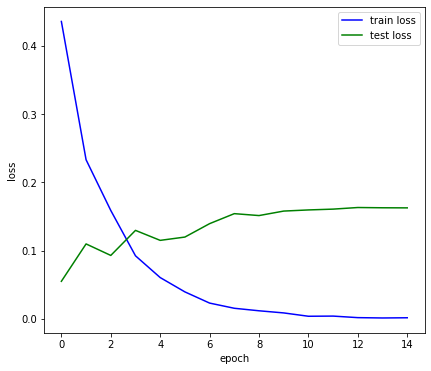

In [ ]:
# Loss 시각화
plt.figure(figsize=(15, 6)) 
plt.subplot(1,2,1)
plt.ylabel('loss'); plt.xlabel('epoch')
plt.plot(train_loss_history, 'b', label='train loss')
plt.plot(test_loss_history, 'g', label='test loss')
plt.legend(loc='best')
plt.show()

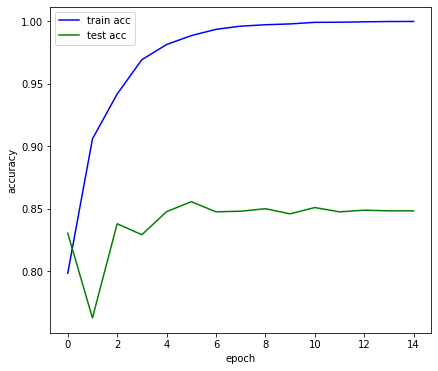

In [ ]:
# Acc 시각화
plt.figure(figsize=(15, 6)) 
plt.subplot(1,2,1)
plt.ylabel('accuracy'); plt.xlabel('epoch')
plt.plot(train_acc_history, 'b', label='train acc')
plt.plot(test_acc_history, 'g', label='test acc')
plt.legend(loc='best')
plt.show()

# Test model

In [28]:
# Model load - min loss
plt.show(); plt.close('all'); plt.clf()
model, optimizer, st_epoch = load(ckpt_dir=checkpoint_path_1, model=model, optim=optimizer)
print(st_epoch)

ValueError: ignored

<Figure size 432x288 with 0 Axes>

In [37]:
# Test model one by one
def softmax(vals, idx):
    valscpu = vals.cpu().detach().squeeze(0)
    a = 0
    for i in valscpu:
        a += np.exp(i)
    return ((np.exp(valscpu[idx]))/a).item() * 100

def testModel(model, seq):
    cate = ["not clean", "clean"]
    tmp = [seq]
    print(tok)
    print(tmp)

    transform = nlp.data.BERTSentenceTransform(tok, max_len, pad=True, pair=False)
    print(transform)
    print("-"*10)
    tokenized = transform(tmp)
    print(tokenized)
    print("-"*10)

    model.eval()
    result = model(torch.tensor([tokenized[0]]).to(device), [tokenized[1]], torch.tensor(tokenized[2]).to(device))
    idx = result.argmax().cpu().item()
    print("문장의 카테고리는:", cate[idx])
    print("신뢰도는:", "{:.2f}%".format(softmax(result,idx)))

In [38]:
testModel(model, "쪼마난게 계속 짖노 ㅋㅋㅋㅋ 황으조 뭐냐고 ㅋㅋㅋ")

['쪼마난게 계속 짖노 ㅋㅋㅋㅋ 황으조 뭐냐고 ㅋㅋㅋ']
----------
(array([   2,  517, 7375, 6141, 5663, 5400,  984,  517, 7358, 5725,  517,
        492,  492,  492,  492, 5149, 7074, 7253, 2145, 5689, 5439,  517,
        492,  492,  492,    3,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32), array(26, dtype=int32), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32))
----------
문장의 카테고리는: not clean
신뢰도는: 98.73%


## Confusion matrix

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/3737 [00:00<?, ?it/s]

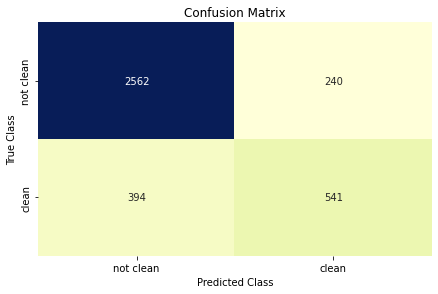

In [ ]:
y_pred = []
y_true = []
test_set = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)
test_input = torch.utils.data.DataLoader(test_set, batch_size=1, num_workers=4)

# inference
model.eval()
with torch.no_grad():
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_input)): 
    token_ids = token_ids.long().to(device) 
    segment_ids = segment_ids.long().to(device) 
    valid_length= valid_length 
    out = model(token_ids, valid_length, segment_ids)
    out = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
    y_pred.extend(out)
    y_true.extend(label.data.cpu().numpy())
  
class_names = ('not clean', 'clean')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

sn.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
plt.title("Confusion Matrix"); plt.tight_layout() 
plt.ylabel("True Class"); plt.xlabel("Predicted Class"); 
plt.savefig('confusion_matrix.png', dpi=300); plt.show()